In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **Random** **Forest** **dan** **KNN**

In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations 

def get_data(comb):
  data = pd.read_csv("drive/My Drive/TA Dengue Fever/Data DBD (4).csv", names=["kecamatan", "kepadatan penduduk", "Tidak Sekolah", "Tidak Tamat SD", 
                      "SD", "SMP", "SMA", "D3", "S1", "mobilitas penduduk", "curah hujan", "kecepatan angin", "kelembaban", "temperatur", "jumlah pengidap"], 
                    sep=",")
  data = data.drop(["Tidak Sekolah", "Tidak Tamat SD", "SD", "SMP", "SMA", "D3", "S1"], axis=1)
  data = data[np.asarray(comb)]
  data = data.dropna()
  data.isnull().values.any()
  return data

def normalization(data):
  scaler = MinMaxScaler()
  data = scaler.fit_transform(data)
  return data

def preprocesing(comb,year):
  data = get_data(comb)
  scaler = 0
  datatemp = pd.DataFrame(data, columns=np.asarray(comb))
  
  atribut = datatemp.drop(["jumlah pengidap"], axis=1)
  atribut = normalization(atribut)
  output = datatemp["jumlah pengidap"]
  atribut = atribut[:-60]
  output = output[:-60]

  # atribut_train = atribut[((year-2)*30)-30:((year-2)*30)]
  # atribut_test = atribut[(year*30)-30:(year*30)]
  # output_train = output[((year-2)*30)-30:((year-2)*30)]
  # output_test = output[(year*30)-30:(year*30)]

  from sklearn.model_selection import train_test_split
  atribut_train, atribut_test, output_train, output_test = train_test_split(atribut, output, test_size=0.2)

  return atribut_train, atribut_test, output_train, output_test, scaler

def mape(output_test, predict):
  true, pred = np.array(output_test), np.array(predict)
  return np.mean(np.abs((true - pred) / true)) * 100

def modelRF(n_estimators, split, atribut_train, atribut_test, output_train, output_test):
  rf_model = RandomForestRegressor(n_estimators=n_estimators, min_samples_split=split)
  rf_model.fit(atribut_train, output_train)
  # rf_mse = mean_squared_error(output_train, rf_model.predict(atribut_train))
  # rf_mae = mean_absolute_error(output_train, rf_model.predict(atribut_train))
  predict = rf_model.predict(atribut_test)
  rf_test_mse = mean_squared_error(output_test, predict)
  rf_test_mae = mean_absolute_error(output_test, predict)  
  rf_mape = mape(output_test, predict)
  return predict,rf_test_mse, rf_test_mae, rf_mape

def modelknn(n_neighbors, p, atribut_train, atribut_test, output_train, output_test):
  knn_model = KNeighborsRegressor(n_neighbors=n_neighbors, algorithm='auto', p=p)
  knn_model.fit(atribut_train, output_train)
  # knn_mse = mean_squared_error(output_train, knn_model.predict(atribut_train))
  # knn_mae = mean_absolute_error(output_train, knn_model.predict(atribut_train))  
  predict = knn_model.predict(atribut_test)
  knn_test_mse = mean_squared_error(output_test, predict)
  knn_test_mae = mean_absolute_error(output_test, predict)
  knn_mape = mape(output_test, predict)
  return predict, knn_test_mse, knn_test_mae, knn_mape

def runall(comb,year):
  atribut_train, atribut_test, output_train, output_test, scaler = preprocesing(comb,year)
  numsplit = [5, 10, 15, 20]
  best_rmse = 1000
  for i in range(64,129):
    for j in numsplit:
      predict_rf, rf_mse, rf_mae, rf_mape = modelRF(i,j, atribut_train, atribut_test, output_train, output_test)      
      if (sqrt(rf_mse)<=best_rmse):
        best_rmse = sqrt(rf_mse)
        best_mape = rf_mape
        best_predict = predict_rf
        best_method = "Random Forest"
        par1 = i
        par2 = j
    # print("metode = KNN RMSE =",sqrt(rf_mse)," MAPE =",rf_mape," Numtree/k =",i," split/p =",j,"\n")  
  # best_rmse = 1000
  for i in range(1,21):
    for j in range(1,3):
      predict_knn, knn_mse, knn_mae, knn_mape = modelknn(i, j, atribut_train, atribut_test, output_train, output_test)
      if (sqrt(knn_mse)<=best_rmse):
        best_rmse = sqrt(knn_mse)
        best_mape = knn_mape
        best_predict = predict_knn
        best_method = "KNN"
        par1 = i
        par2 = j
    # print("metode = Random Forest RMSE =",sqrt(knn_mse)," MAPE =",knn_mape," Numtree/k =",i," split/p =",j,"\n")
  # print("metode =",best_method," RMSE =",best_rmse," MAPE =",best_mape," Numtree/k =",par1," split/p =",par2,"\n")
  return best_predict, best_method, best_rmse, par1, par2, scaler, best_mape

def run_comb(comb,x,year):
  best_rmse = 1000
  for i in list(comb):
    # print("(",x,") kombinasi parameter = ",i)
    predict, method, rmse, par1, par2, scaler, mape = runall(i +("kecamatan", "jumlah pengidap",),year)
    if (rmse < best_rmse):
      best_predict = predict
      best_rmse = rmse
      best_mape = mape
      best_method = method
      best_comb = i
      best_par1 = par1
      best_par2 = par2
  return best_predict, best_rmse, best_method, best_comb, best_comb, best_par1, best_par2, scaler, best_mape

def run_scenario(year):
  comb1 = combinations(["kepadatan penduduk", "mobilitas penduduk", "curah hujan", "kecepatan angin", "kelembaban", "temperatur"], 4)
  comb2 = combinations(["kepadatan penduduk", "mobilitas penduduk", "curah hujan", "kecepatan angin", "kelembaban", "temperatur"], 5)
  best_predict1, best_rmse1, best_method1, best_comb1, best_comb1, best_par11, best_par21, scaler, best_mape1 = run_comb(comb1,4,year)
  best_predict2, best_rmse2, best_method2, best_comb2, best_comb2, best_par12, best_par22, scaler, best_mape2 = run_comb(comb2,5,year)
  if (best_rmse2 < best_rmse1):
    best_rmse1 = best_rmse2
    best_mape1 = best_mape2
    best_method1 = best_method2
    best_comb1 = best_comb2
    best_par11 = best_par12
    best_par21 = best_par22
    best_predict1 = best_predict2
  print("best combination")
  print("comb =",best_comb1," method =",best_method1," rmse =",best_rmse1," MAPE =",best_mape1," numtree/k = ",best_par11," split/p =",best_par21)
  # print(best_predict1)

# sumsum = []
for i in range(5):
  print("loop -",i)
  run_scenario(i)
  # sumsum.append(mape)
# print("Rata-Rata =", np.sum(sumsum)/5,"%")



loop - 0
best combination
comb = ('kepadatan penduduk', 'mobilitas penduduk', 'curah hujan', 'kecepatan angin')  method = Random Forest  rmse = 47.81362912158871  MAPE = 49.18993765575024  numtree/k =  75  split/p = 20
loop - 1
best combination
comb = ('mobilitas penduduk', 'kecepatan angin', 'kelembaban', 'temperatur')  method = KNN  rmse = 45.703505518358945  MAPE = 59.36334314242494  numtree/k =  20  split/p = 1
loop - 2
best combination
comb = ('kepadatan penduduk', 'curah hujan', 'kelembaban', 'temperatur')  method = KNN  rmse = 50.44978137486177  MAPE = 76.98582358276163  numtree/k =  11  split/p = 2
loop - 3
best combination
comb = ('kepadatan penduduk', 'curah hujan', 'kecepatan angin', 'temperatur')  method = Random Forest  rmse = 45.965811129632975  MAPE = 35.350543592748615  numtree/k =  95  split/p = 20
loop - 4
best combination
comb = ('kepadatan penduduk', 'mobilitas penduduk', 'kelembaban', 'temperatur')  method = Random Forest  rmse = 49.298236844408045  MAPE = 58.49977

In [0]:
data = get_data(best_comb1+("kecamatan", "jumlah pengidap",))
realdata = data[-30:]
print(realdata)
realdata = realdata["jumlah pengidap"]
# data = scaler.fit_transform(data)
inverse = data[-30:] 

# for i in range(30):
#   inverse[i-1,5] = best_predict1[i-1]

# inverse = scaler.inverse_transform(inverse)
# print(inverse[:,5])
# print(realdata)

for i in range(30):
  best_predict1[i] = round(best_predict1[i])

j = 0
sum = 0
akurasi = 0
for i in realdata:
  sum = sum + (best_predict1[j] - i)**2
  akurasi += np.abs(best_predict1[j] - i)/i *100
  print("real : ",i," || ",best_predict1[j]," : prediction")
  j = j + 1
print("Akurasi = ",100-akurasi/30,"%")
print("RMSE = ",sqrt(sum/30))


     kepadatan penduduk  kecepatan angin  ...  kecamatan  jumlah pengidap
180              265.36              4.0  ...          1               67
181              198.23              4.0  ...          2              129
182              116.62              4.6  ...          3               96
183              240.65              4.0  ...          4               90
184              200.56              4.0  ...          5               89
185               98.82              4.0  ...          6               74
186              223.91              4.0  ...          7               47
187               91.75              4.0  ...          8               35
188              242.58              4.6  ...          9              162
189              403.57              4.0  ...         10               89
190              139.33              4.6  ...         11               84
191              121.28              4.0  ...         12              133
192              159.58              4

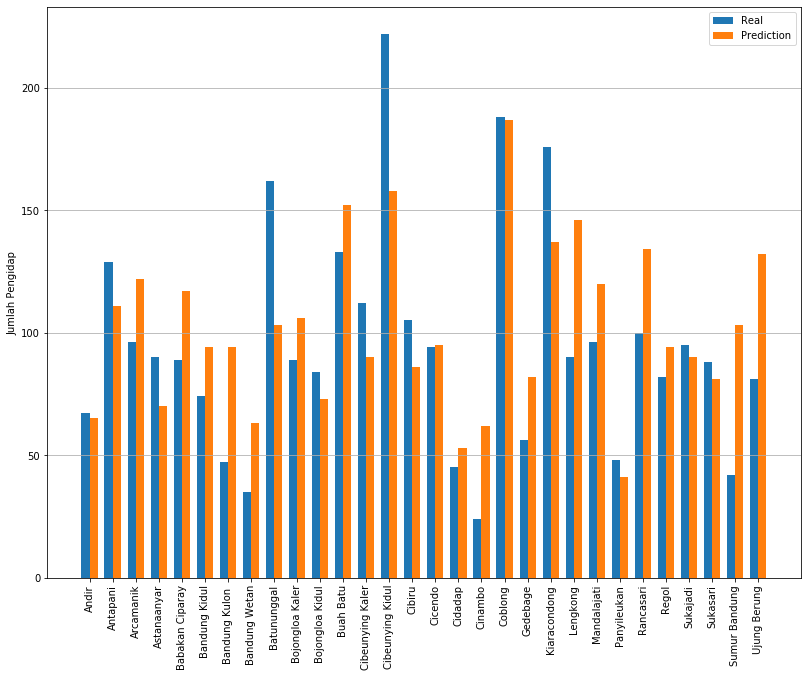

In [0]:
import matplotlib.pyplot as plt

labels = ['Andir', 'Antapani', 'Arcamanik', 'Astanaanyar', 'Babakan Ciparay', 'Bandung Kidul', 'Bandung Kulon ', 'Bandung Wetan', 
          'Batununggal', 'Bojongloa Kaler', 'Bojongloa Kidul', 'Buah Batu', 'Cibeunying Kaler', 'Cibeunying Kidul', 'Cibiru', 'Cicendo', 
          'Cidadap', 'Cinambo', 'Coblong', 'Gedebage', 'Kiaracondong', 'Lengkong', 'Mandalajati', 'Panyileukan', 'Rancasari', 'Regol', 'Sukajadi',
          'Sukasari', 'Sumur Bandung', 'Ujung Berung']
prediction = best_predict1
real = realdata

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, real, width, label='Real')
rects2 = ax.bar(x + width/2, prediction, width, label='Prediction')

ax.set_ylabel('Jumlah Pengidap')
# ax.set_title('Perbandingan Prediksi dan Data Asli tahun 2018')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.yaxis.grid(True)
plt.xticks(x, labels, rotation='vertical')

fig.set_size_inches(13.5, 10.5, forward=True)
plt.savefig('perbandingan.png')
plt.show()




# **KLASIFIKASI KERAWANAN**

In [0]:


kepadatan = [95392, 69434, 67047, 67346, 144303, 57838, 139708, 30283, 118231, 118118, 84141, 93074, 69456, 105568, 69276, 97544, 57156, 24345, 128800, 35458, 127616, 69837, 61829, 38725, 74188, 79923, 105963, 80086, 35293, 74196]

last_predict = []
x = 0;
for i in best_predict1:
  temp = (kepadatan[x]/100000) * i
  if (temp>55):
    last_predict.append('High')
  elif (temp>=20):
    last_predict.append('Medium')
  else :
    last_predict.append('Low')
  x += 1
print(last_predict)


['High', 'High', 'High', 'Medium', 'High', 'Medium', 'High', 'Low', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'Medium', 'Low', 'High', 'Medium', 'High', 'High', 'High', 'Low', 'High', 'High', 'High', 'High', 'Medium', 'High']


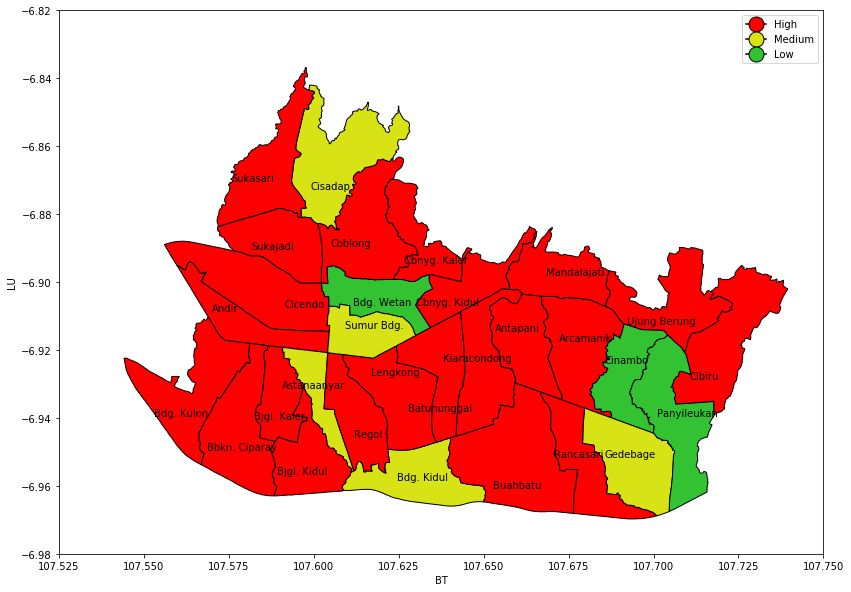

In [0]:
# !pip install geopandas
# !pip install pysal

import geopandas as gpd
# import pysal as ps
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

df_places = gpd.read_file('drive/My Drive/TA Dengue Fever/kota-bandung-level-kecamatan.json')
df_places = df_places.sort_values('KECAMATAN')
df_places['Luas_Km_'] = last_predict

datacamat = pd.read_csv("drive/My Drive/TA Dengue Fever/camat.csv", sep=",")
namcam=datacamat['Kecamatan']
korx=datacamat['X']
kory=datacamat['Y']

colors = {'High' : 'Red',
          'Medium' : '#d7e314',
          'Low' : '#32c232'}

c = [colors[val] for val in df_places['Luas_Km_']]
ax = df_places.plot(legend=True, figsize=(16, 10), edgecolor='black', color = c)
# ax.set_title("Prediksi Penyakit DBD Tahun 2018", fontsize=25)
ax.set_xlim(107.525,107.750)
ax.set_ylim(-6.98,-6.82)
ax.set_xlabel("BT")
ax.set_ylabel("LU")
legend_elements = [Line2D([0], [0], marker='o', color='black', label='High', markerfacecolor='Red', markersize=15),
                   Line2D([0], [0], marker='o', color='black', label='Medium', markerfacecolor='#d7e314', markersize=15),
                   Line2D([0], [0], marker='o', color='black', label='Low', markerfacecolor='#32c232', markersize=15)]
ax.legend(handles=legend_elements)

import logging
logging.getLogger().setLevel(logging.CRITICAL)

for i in range(0,len(datacamat)):
  plt.text(  # position text relative to data
            korx[i], kory[i], namcam[i],  # x, y, text,
            ha='center', va='bottom', color="black"  , # text alignment,
            transform=ax.transData      # coordinate system transformation
          )
plt.savefig('Peta Penyakit DBD.png')